# Bayesian Gaussian Mixture Modeling using TensorFlow Probability

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tf.compat.v1.disable_eager_execution()  # Eager execution is disabled as it significantly slows down MCMC

import sys
import time
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from operator import mul
from sklearn.cluster import KMeans

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.1.0-dev20191015
TensorFlow Probability version: 0.9.0-dev20191016


In [2]:
def session_options(enable_gpu_ram_resizing=True):
    """Convenience function which sets common `tf.Session` options."""
    config = tf.compat.v1.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    return config

def reset_sess(config=None):
    """Convenience function to create the TF graph and session, or reset them."""
    if config is None:
        config = session_options()
    tf.compat.v1.reset_default_graph()
    global sess
    try:
        sess.close()
    except:
        pass
    sess = tf.compat.v1.InteractiveSession(config=config)

reset_sess()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P1000, pci bus id: 0000:01:00.0, compute capability: 6.1



## Generate some data

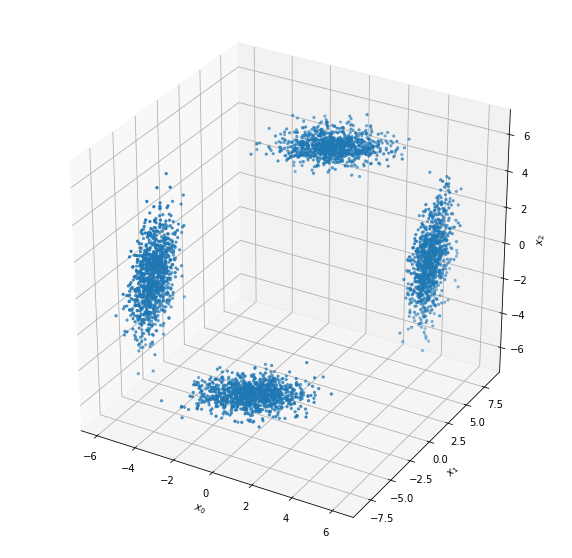

In [3]:
eps = 1e-6

n_samples_per_component = 1000
n_dims = 3
X = []
X.append(np.random.multivariate_normal([5, 5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([-5, -5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([0, 5, 5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([0, -5, -5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float64'))
n_components = len(X)
n_samples = n_samples_per_component * n_components
X = np.concatenate(X)

# Plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
plt.show()

## Build a Gaussian Mixture Model
$$
\begin{aligned}
\mathbf{x}_n &\sim \sum\limits_k \pi_k \mathcal{N}\left(\pmb{\mu_x}_k, \pmb{\Sigma_x}_k\right)\\
\pi_k &\sim \mathcal{D}\left(K, \mathbf{c}\right)\\
\forall k \quad&\left\{
    \begin{aligned}
    \pmb{\Sigma_x}_k^{-1} &\sim \mathcal{W}\left(\mathbf{W}, \nu\right)\\
    \pmb{\mu_x}_k &\sim \mathcal{N}\left(\pmb{\mu_0}, \pmb{\Sigma_0}\right)
    \end{aligned}
\right.
\end{aligned}
$$

### prior distributions

In [4]:
theta_prior = tfd.Dirichlet(
    concentration=2 * np.ones(n_components, dtype=np.float64), name='theta_prior',
    validate_args=True, allow_nan_stats=False)

mu_prior = tfd.Independent(
    tfd.Normal(loc=np.stack([np.zeros(n_dims, dtype=np.float64)] * n_components),
               scale=tf.ones((n_components, n_dims), dtype=np.float64),
               validate_args=True, allow_nan_stats=False),
    reinterpreted_batch_ndims=1,
    name='mu_prior',
    validate_args=True)

invcov_chol_prior = tfd.WishartTriL(df=n_dims+2,
                                    scale_tril=np.stack([np.eye(n_dims, dtype=np.float64)] * n_components),
                                    input_output_cholesky=True,
                                    name='invcov_chol_prior',
                                    validate_args=True, allow_nan_stats=False)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


### joint log probability

In [5]:
def joint_log_prob(x, theta, mu, invcov_chol):
    """BGMM with priors: theta=Dirichlet, mu=Normal, invcov_chol=Wishart

    Args:
    x: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian Mixture model draws.
       Each sample is a length-`d` vector.
    theta: `[K]`-shaped `Tensor` representing random draw from `SoftmaxInverse(Dirichlet)` prior.
    mu: `[K, d]`-shaped `Tensor` representing the location parameter of the `K` components.
    invcov_chol: `[K, d, d]`-shaped `Tensor` representing `K` lower triangular `cholesky(Precision)` matrices,
                 each being sampled from a Wishart distribution.

    Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
    """
    cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

    gmm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=theta),
        components_distribution=tfd.MultivariateNormalTriL(loc=mu,
                                                           scale_tril=tf.linalg.cholesky(cov)))
    log_prob_parts = [
        gmm.log_prob(x),  # log probabilities (summed to be log-likelihoods)
        theta_prior.log_prob(theta)[..., tf.newaxis],  # prior probabilities of theta
        mu_prior.log_prob(mu),  # prior probabilities of mu
        invcov_chol_prior.log_prob(invcov_chol)  # prior probabilities of invcov_chol
    ]
    sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)  # joint log probabilities
    return sum_log_prob

## Bayesian Inference using Markov chain Monte Carlo (MCMC) algorithms

In [6]:
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, X)

### set up initial states

In [7]:
initial_state = [
    (1 / n_components) * tf.ones(n_components, dtype=tf.float64, name='theta'),
    tf.convert_to_tensor(np.array([[5, 5, 0],
                                   [-5, -5, 0],
                                   [0, 5, 5],
                                   [0, -5, -5]], dtype=np.float64),
                         name='mu'),
    tf.linalg.diag(tf.ones((n_components, n_dims), dtype=tf.float64), name='invcov_chol')
]

### unconstrained representation
MCMC requires the target log-probability function be differentiable with respect to its arguments. Furthermore, MCMC can exhibit dramatically higher statistical efficiency if the state-space is unconstrained.

To address this requirement we'll need to:

1. transform the constrained variables to an unconstrained space;
2. run the MCMC in unconstrained space;
3. transform the unconstrained variables back to the constrained space.

In [8]:
# bijectors transforms the unconstrained variables back to the constrained space
unconstraining_bijectors = [
    tfb.SoftmaxCentered(validate_args=True),  # transform unconstrained theta values to discrete probability vectors
    tfb.Identity(validate_args=True),  # identity transformation (no transformation) for mu values
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus(), validate_args=True),
        tfb.FillTriangular(validate_args=True)
    ])  # transforms unconstrained invcov_chol values to lower triangular matrices with positive diagonal
]

### graph for Random Walk Metropolis (RWM) sampling (Method 1)

In [9]:
n_results = 16000
n_burnin_steps = 8000
scale = 1e-3
[theta, mu, invcov_chol], kernel_results = tfp.mcmc.sample_chain(num_results=n_results,
                                                                 num_burnin_steps=n_burnin_steps,
                                                                 current_state=initial_state,
                                                                 kernel=tfp.mcmc.TransformedTransitionKernel(
                                                                     inner_kernel=tfp.mcmc.RandomWalkMetropolis(
                                                                         target_log_prob_fn=unnormalized_posterior_log_prob,
                                                                         new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=scale)),
                                                                     bijector=unconstraining_bijectors),
                                                                 parallel_iterations=100)

Instructions for updating:
`AffineLinearOperator` bijector is deprecated; please use `tfb.Shift(loc)(tfb.MatvecLinearOperator(...))`.


C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


### launch the graph and display the inferred statistics

In [10]:
acceptance_rate = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float64))

theta = theta[n_burnin_steps:]
mu = mu[n_burnin_steps:]
invcov_chol = invcov_chol[n_burnin_steps:]
cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

mean_theta = tf.reduce_mean(theta, axis=0)
mean_mu = tf.reduce_mean(mu, axis=0)
mean_invcov_chol = tf.reduce_mean(invcov_chol, axis=0)
mean_cov = tf.reduce_mean(cov, axis=0)

start_time = time.time()
[val_acceptance_rate, val_mean_theta, val_mean_mu, val_mean_invcov_chol, val_mean_cov] = sess.run(
    [acceptance_rate, mean_theta, mean_mu, mean_invcov_chol, mean_cov])
elapsed_time = time.time() - start_time
print('elapsed time: {:.2f}s'.format(elapsed_time))

print('acceptance_rate:', val_acceptance_rate)
print('avg mix probs:', val_mean_theta)
print('\navg loc:\n', val_mean_mu)
print('\navg precision cholesky:\n', val_mean_invcov_chol)
print('\navg covariance matrix:\n', val_mean_cov)

elapsed time: 9595.37s
acceptance_rate: 0.862625
avg mix probs: [0.24844049 0.25512503 0.24762867 0.24880581]

avg loc:
 [[ 4.99136968  5.02519328  0.12765716]
 [-4.98041703 -4.97772828 -0.0572409 ]
 [ 0.00996063  5.02680586  5.00870718]
 [-0.0314585  -4.98221856 -4.99639094]]

avg precision cholesky:
 [[[ 2.47709883  0.          0.        ]
  [ 0.05957447  1.10980288  0.        ]
  [-0.01921852 -0.35457543  0.70271206]]

 [[ 2.46778401  0.          0.        ]
  [-0.0616935   1.0843033   0.        ]
  [ 0.00980305 -0.31878146  0.69907693]]

 [[ 1.23256135  0.          0.        ]
  [-0.67339941  0.97340591  0.        ]
  [-0.15097277  0.21016192  2.05898233]]

 [[ 1.25751358  0.          0.        ]
  [-0.76347918  0.99049323  0.        ]
  [-0.10465556 -0.03029713  2.09267267]]]

avg covariance matrix:
 [[[ 1.65442030e-01 -1.91825730e-02 -3.96328617e-05]
  [-1.91825730e-02  1.01935527e+00  6.47246881e-01]
  [-3.96328617e-05  6.47246881e-01  2.02602839e+00]]

 [[ 1.66775947e-01  2.286

### graph for Hamiltonian Monte Carlo (HMC) sampling (Method 2)

In [11]:
n_results = 4000
n_burnin_steps = 2000
step_size = 1e-2
num_leapfrog_steps = 10
[theta, mu, invcov_chol], kernel_results = tfp.mcmc.sample_chain(num_results=n_results,
                                                                 num_burnin_steps=n_burnin_steps,
                                                                 current_state=initial_state,
                                                                 kernel=tfp.mcmc.TransformedTransitionKernel(
                                                                     inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                                                                         target_log_prob_fn=unnormalized_posterior_log_prob,
                                                                         step_size=step_size,
                                                                         num_leapfrog_steps=num_leapfrog_steps),
                                                                     bijector=unconstraining_bijectors),
                                                                 parallel_iterations=100)

C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


### launch the graph and display the inferred statistics

In [12]:
acceptance_rate = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float64))

theta = theta[n_burnin_steps:]
mu = mu[n_burnin_steps:]
invcov_chol = invcov_chol[n_burnin_steps:]
cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

mean_theta = tf.reduce_mean(theta, axis=0)
mean_mu = tf.reduce_mean(mu, axis=0)
mean_invcov_chol = tf.reduce_mean(invcov_chol, axis=0)
mean_cov = tf.reduce_mean(cov, axis=0)

start_time = time.time()
[val_acceptance_rate, val_mean_theta, val_mean_mu, val_mean_invcov_chol, val_mean_cov] = sess.run(
    [acceptance_rate, mean_theta, mean_mu, mean_invcov_chol, mean_cov])
elapsed_time = time.time() - start_time
print('elapsed time: {:.2f}s'.format(elapsed_time))

print('acceptance_rate:', val_acceptance_rate)
print('avg mix probs:', val_mean_theta)
print('\navg loc:\n', val_mean_mu)
print('\navg precision cholesky:\n', val_mean_invcov_chol)
print('\navg covariance matrix:\n', val_mean_cov)

elapsed time: 1529.73s
acceptance_rate: 0.87025
avg mix probs: [0.2498434  0.25009479 0.25014161 0.2499202 ]

avg loc:
 [[ 4.99109595  5.01778177  0.10850991]
 [-4.983237   -4.97558152 -0.03743145]
 [-0.0129128   5.01482     5.00213167]
 [ 0.02351644 -4.97109919 -5.005098  ]]

avg precision cholesky:
 [[[ 3.06681467  0.          0.        ]
  [ 0.07086182  1.1076119   0.        ]
  [-0.0261507  -0.34831598  0.70353157]]

 [[ 3.05631866  0.          0.        ]
  [-0.05208389  1.0710462   0.        ]
  [ 0.00821412 -0.31225647  0.70647403]]

 [[ 1.24444161  0.          0.        ]
  [-0.74107702  1.01483969  0.        ]
  [-0.08706177  0.13554366  2.22257539]]

 [[ 1.24503975  0.          0.        ]
  [-0.7727238   0.9953581   0.        ]
  [ 0.01202825 -0.06615687  2.25012359]]]

avg covariance matrix:
 [[[ 1.07148881e-01 -1.80524840e-02  2.55286089e-03]
  [-1.80524840e-02  1.01724448e+00  6.36348312e-01]
  [ 2.55286089e-03  6.36348312e-01  2.02299863e+00]]

 [[ 1.07701479e-01  1.6224

### graph for Metropolis-adjusted Langevin algorithm (MALA) sampling (Method 3)

In [13]:
n_results = 4000
n_burnin_steps = 2000
step_size = 2e-4
[theta, mu, invcov_chol], kernel_results = tfp.mcmc.sample_chain(num_results=n_results,
                                                                 num_burnin_steps=n_burnin_steps,
                                                                 current_state=initial_state,
                                                                 kernel=tfp.mcmc.TransformedTransitionKernel(
                                                                     inner_kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
                                                                         target_log_prob_fn=unnormalized_posterior_log_prob,
                                                                         step_size=step_size),
                                                                     bijector=unconstraining_bijectors),
                                                                 parallel_iterations=100)

C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


### launch the graph and display the inferred statistics

In [14]:
acceptance_rate = tf.reduce_mean(tf.cast(kernel_results.inner_results.is_accepted, tf.float64))

theta = theta[n_burnin_steps:]
mu = mu[n_burnin_steps:]
invcov_chol = invcov_chol[n_burnin_steps:]
cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

mean_theta = tf.reduce_mean(theta, axis=0)
mean_mu = tf.reduce_mean(mu, axis=0)
mean_invcov_chol = tf.reduce_mean(invcov_chol, axis=0)
mean_cov = tf.reduce_mean(cov, axis=0)

start_time = time.time()
[val_acceptance_rate, val_mean_theta, val_mean_mu, val_mean_invcov_chol, val_mean_cov] = sess.run(
    [acceptance_rate, mean_theta, mean_mu, mean_invcov_chol, mean_cov])
elapsed_time = time.time() - start_time
print('elapsed time: {:.2f}s'.format(elapsed_time))

print('acceptance_rate:', val_acceptance_rate)
print('avg mix probs:', val_mean_theta)
print('\navg loc:\n', val_mean_mu)
print('\navg precision cholesky:\n', val_mean_invcov_chol)
print('\navg covariance matrix:\n', val_mean_cov)

elapsed time: 759.22s
acceptance_rate: 0.6435
avg mix probs: [0.24883278 0.24951683 0.25063191 0.25101848]

avg loc:
 [[ 4.99119668  5.01439659  0.10412371]
 [-4.98318399 -4.97404597 -0.03899816]
 [-0.01031765  5.01830767  5.00120453]
 [ 0.02402447 -4.969517   -5.00546928]]

avg precision cholesky:
 [[[ 3.05036607  0.          0.        ]
  [ 0.07515016  1.10424112  0.        ]
  [-0.0280067  -0.34487696  0.70550916]]

 [[ 3.03637912  0.          0.        ]
  [-0.06450821  1.07119057  0.        ]
  [ 0.01557511 -0.31028529  0.70706238]]

 [[ 1.25064862  0.          0.        ]
  [-0.7510701   1.0170769   0.        ]
  [-0.07914385  0.1028017   2.22949531]]

 [[ 1.24028647  0.          0.        ]
  [-0.76607108  0.99803328  0.        ]
  [ 0.0452747  -0.02509068  2.24655694]]]

avg covariance matrix:
 [[[ 1.08363041e-01 -1.93511679e-02  2.95535839e-03]
  [-1.93511679e-02  1.01813455e+00  6.28355810e-01]
  [ 2.95535839e-03  6.28355810e-01  2.01194212e+00]]

 [[ 1.09282689e-01  1.914139